# Machine Learning Engineer Nanodegree
## Capstone Project - Who Wrote This? 
... or how to identify the author of anonymous articles using natural languange processing.

Stefan Dittforth  
February 27th, 2018

--------------

## Sources:

[1] ["Who’s At The Keyboard? Authorship Attribution in Digital Evidence Investigations"](www.utica.edu/academic/institutes/ecii/publications/articles/B49F9C4A-0362-765C-6A235CB8ABDFACFF.pdf): good reference regarding number of authors and text volume.

[2] ["How a Computer Program Helped Show J.K. Rowling write A Cuckoo’s Calling"](https://www.scientificamerican.com/article/how-a-computer-program-helped-show-jk-rowling-write-a-cuckoos-calling/): some good ideas for feature to analyse.

[3] [How to solve 90% of NLP problems: a step-by-step guide](https://blog.insightdatascience.com/how-to-solve-90-of-nlp-problems-a-step-by-step-guide-fda605278e4e)

[4] [scikit learn documentation: confusion matrix](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py)

[5] Jason Brownlee book

[6] http://ruder.io/deep-learning-nlp-best-practices/index.html#wordembeddings

[7] https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/



## Research Notes:

- add some article screen shots to the text
- test approaches suggested in [1]
- measure average word lentgh per article, distribution of word lengths, the 100 most common words, distribution of character 4-grams, word bigrams
- test with support vector machines
- using word embeddings as a much rich representation
Some good tips from [3]:
- Clean data:
    - Remove all irrelevant characters such as any non alphanumeric characters
    - Tokenize your text by separating it into individual words
    - Remove words that are not relevant, such as “@” twitter mentions or urls
    - Convert all characters to lowercase, in order to treat words such as “hello”, “Hello”, and “HELLO” the same
    - Consider combining misspelled or alternately spelled words to a single representation (e.g. “cool”/”kewl”/”cooool”)
    - Consider lemmatization (reduce words such as “am”, “are”, and “is” to a common form such as “be”)
- do random guess model
- One-hot encoding (Bag of Words)
- do we do bag-of-words on sentence level or article level? hmm ...
- apply PCA to visualise bag of words
- start with testing logistic regression for classification
- visualise confusion matrix
- vocabulary structure TF-IDF
- Word2Vec?
- LSTM
- Convolutional Neural Networks for Sentence Classification





----------------
## Introduction

write some introduction

----------------
## Data Acquisition

In order to allow the system to learn the writing characteristics of different authors we require a dataset that provides a large number of articles for individual authors. There are rich datasets for NLP research available in the public domain. A list, as an example, can be found [here](https://github.com/niderhoff/nlp-datasets). However, as part of this project we will build our own dataset. We will develop a web scraper that will collect articles from the publishing platform Medium. The articles on Medium seem to be reasonably long (at least several hundred words). There are enough authors that have published several hundreds articles. With this, it appears feasible to acquire a large enough data set to learn patterns in the writing characteristics to distinguish between individual authors.

This approach has been chosen as an opportunity to develop practical experience not only in machine learning but also around data acquisition. In data science and machine learning the acquisition and preparation of high quality data is often the bigger challenge than the actual development of the machine learning system itself. In "[Datasets Over Algorithms](https://www.edge.org/response-detail/26587)" author Alexander Wissner-Gross notes that 

>*"the average elapsed time between key [machine learning] algorithm proposals and corresponding advances was about eighteen years, whereas the average elapsed time between key dataset availabilities and corresponding advances was less than three years, or about six times faster, suggesting that datasets might have been limiting factors in the advances."*.

Conveniently the website [Top Authors](https://topauthors.xyz/) has published a list of 300+ top Medium authors. The project folder contains the short script `get_list_of_Medium_authors.py` that has been used to extract the Medium URL for each author. The initial list of 300+ authors has been reduced to 25. The criteria for this reduction was the number of published articles. For the 25 authors there are at least 300 articles available. The Medium URLs for these authors can be found in file `Medium_authors_25.txt`.

<img src="notebook/Top Authors.jpg" alt="Drawing" style="width: 400px;"/>
<center>*getting a list of Medium 
authors*</center>

The actual collection of the articles is done with the script `pull_Medium_articles.py`. The script performs two steps. First, it builds a list of all article URLs and for each article saves author URL and article URL in JSON format in the file `Medium_article_urls.json`. Below is an example how the entries for three articles look like.

```javascript
{"author_URL": "https://medium.com/@tedr/latest\n",
 "article_URL": "https://medium.com/season-of-the-witch/etiquette-and-the-cancer-patient-630a50047448?source=user_profile---------1----------------"}
{"author_URL": "https://medium.com/@esterbloom/latest\n",
 "article_URL": "https://medium.com/the-billfold/failing-at-shoplifting-life-with-kesha-bc2600b1f440?source=user_profile---------789----------------"}
{"author_URL": "https://medium.com/@gassee/latest",
 "article_URL": "https://mondaynote.com/the-ny-times-un-free-at-last-df2eddba360b?source=user_profile---------281----------------"}
```

The second part performs the actual download of the articles. The script reads the article URL saved in `Medium_article_urls.json`, navigates to the website and reads the text information from the html code of the article website. Each article is saved in text format in its own file. For each author a folder is generated that contains the articles for that author. Initially it was intended to store all articles in JSON format in one file. This turned out to be very cumbersome when troubleshooting the `pull_Medium_articles.py` script. Having a folder structure that allows to do quick visual inspections over the list of files in a file manager proved very helpful. In addition, the smaller article files made it easier to spot check the downloaded text information in a text editor.

During research for this project several Python libraries for interacting with websites have been explored: [mechanize](https://pypi.python.org/pypi/mechanize/0.3.6), [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#), [scrapy](https://scrapy.org/) and the [Selenium WebDriver](https://www.seleniumhq.org/projects/webdriver/). Eventually the decision was made to use the Selenium WebDriver. The key reason for this was: the Medium website uses a two step login process. The users provides its email address and then receives a one time login link via this email. That made it difficult to automate the login via script and ruled out all the libraries that don't allow user interaction with the website.

Once an article website is loaded, the required information can be pulled from the text attribute of specific html elements. The code snipped below shows the commands used to get the author name and the article text.

```python
author = self.browser.find_element_by_xpath('//a[@rel="author cc:attributionUrl"]').text
body = self.browser.find_element_by_xpath('//div[@class="postArticle-content js-postField js-notesSource js-trackedPost"]').text
```

As shown in the code snippet above the right elements are addressed by their respective xpath. Finding these xpaths required a bit of trail and error. A valuable tool for this is the FireFox Inspector. It allows to inspect the code and structure of a website and to find the right path to the right html element.

![Top Authors](notebook\Firefox Inspector.jpg)
<center>*finding the right xpath with Firefox Inspector*</center>

After the `pull_Medium_articles.py` script completed, the folder `Medium_articles` containing all article files has been compressed into a ZIP archive to preserve storage. With [`zipfile`](https://docs.python.org/3/library/zipfile.html) Python provides a library to work with ZIP archives. Going forward in this Notebook we will make use of this library to work with the files directly within the ZIP archive without the need to extract the archive.

Developing a web scraper script poses its own challenges. The initial idea is pretty straightforward: here is a list of URLs, go to each website, download the text part and save it in a file. As always, the pitfalls are discovered during implementation. Some time had to be invested to understand the structure of the Medium article websites and figure out the best way to find the right html elements that contain the required information. The Selenium WebDriver is not the most effective tool when it comes to scraping several thousand websites. The time to render each and every website adds up. An attempt has been made by parallelising the article download with multi-threading and spawning of several instances of the Firefox browser. This failed. It turned out that the fast sequence of websites caused Firefox to slowly consume all available memory and eventually Firefox stopped fetching new websites. In a parallelised version of the script the problem was only exaggerated. Finally, a pragamatic approach was taken and the script has been amended with the capability to continue the work where it has left off from a previous run. Over the course of several days the script has been restarted several times and eventually saved all articles.

In defense for Selenium, it needs to be noted that Selenium first and foremost is a tool to automate testing of websites and not a tool for scaping several thousand websites. The primary goal behind the `pull_Medium_articles.py` script was to get the data for this capstone project and not to develop a sophisticated web scraper. In this respect Selenium did the job. Despite the challenges, developing the web scraper script has been a worthwhile learing experience. It provided an opportunity to develop practical experience not only in machine learning but also around data acquisition.

In the next section we will explore the data set. We will also check what data preparation or cleaning activities might be required before we can apply algorithms  to the data set.

----------------
## Exploring the Data Set

All articles have been downloaded in individual text files and into folders for each author. This folder and file structure has been archived into `Medium_articles.zip`. Let's go through the files and get an overview about the data set. 

In [31]:
# We use this code block to load all the libraries we will need
# throughout the Notebook. Keeping all library calls in one place at
# beginning allows to run other code cells more independently.

import zipfile
import json
import pandas as pd
import re
import random
import string
import pprint
import pickle
import hashlib
import time
import itertools
import os.path
import matplotlib.pyplot as plt
import numpy as np
from numpy import asarray
from numpy import zeros
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cycler import cycler
from sklearn import tree
from sklearn import linear_model
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

# some global settings for the Notebook
%matplotlib inline
plt.style.use('seaborn-whitegrid')
plt.rcParams["figure.figsize"] = [13, 13]

In [3]:
def get_next_article_from_zip_file(file_name):
    """
    A generator function that reads the files in a zip archive one by one.
    """
    zf = zipfile.ZipFile(file_name, 'r')
    names = zf.namelist()
    for name in names:
        if name.endswith('.json'):
            data = zf.read(name)
            yield data
    zf.close()
    return

# read all articles into a pandas data frame
articles = pd.DataFrame(columns=['url', 'author', 'headline', 'body'])
for article_file in get_next_article_from_zip_file('Medium_articles.zip'):
    article = json.loads(article_file)
    articles = articles.append(json.loads(article_file), ignore_index=True)

In [100]:
# show a list of authors and the number of articles for each author
summary = articles[['author', 'body']].groupby('author').count()
summary.columns = ['number of articles']
display(summary.sort_values('number of articles', ascending=False))
print('Total number of articles: {:,}'.format(len(articles)))

,number of articles
author,
Nicole Dieker,1948
Fabricio Teixeira,1733
Ester Bloom,1328
Ethan Siegel,1323
Yann Girard,1042
Pascal Finette,1020
Jon Westenberg 🌈,932
Chris Messina,872
Mark Suster,825


Total number of articles: 18,564


## Cleaning the Dataset

The articles were downloaded by extracting the 'text' attribute from html elements that contain the body text of the article. Many articles contain images, URLs to other pages, etc. We are interested to see if the text extracts still contain html fragments we might need to clean out. We do a qick check by listing the articles that contain the '<' and '>' characters. Those two characters enclose HTML tags. 

In [101]:
regex = r'<.*>' # find any HTML tag enclosing brackets
counter = 0
for index, article in articles.iterrows():
    matches = re.finditer(regex, article['body'], re.DOTALL)
    for matchNum, match in enumerate(matches):
        counter = counter + 1
        print('Match number: {}'.format(counter))
        print('Match in article index: {}'.format(index))
        print(article['url'])
        print(match.group())

Match number: 1
Match in article index: 239
https://medium.com/@bfeld/people-are-the-price-of-admission-7782d2c55bba?source=user_profile---------85----------------
<riff>
We have a set of filters. For an early stage investment, we only invest in our themes. We only invest in the US. We don’t have to be the first money in a company, but if the company has raised more than $5m, it’s too late for us. Our goal with this filter is to say no to almost everything within 60 seconds.
Assuming something passes through this filter, we then focus on three things.
Do we have an affinity for the product? We don’t have to be daily users of the product, but we have to care about it in some way.
Are the founders obsessed (not passionate, but obsessed) about what they are building? Passion is easy to fake. Obsession is not.
Do the founders want us to be investors in their company as much as we want to be investors in their company? If it’s not bi-directional, that’s fine, but it’s not for us.
</riff>
Ma

https://medium.com/@howardlindzon/twenty-minute-vc-interview-howard-lindzon-72f8c38d86f7?source=user_profile---------615----------------
< (just press click to play on his site)/a>
Match number: 29
Match in article index: 6924
https://medium.com/the-mission/how-to-be-a-bad-leader-bfeebb16ca8f?source=user_profile---------472----------------
< 30 people, < 150 people, >
Match number: 30
Match in article index: 7396
https://mondaynote.com/a-salute-to-walt-mossberg-e3c562288f03?source=user_profile---------21----------------
<re/code>
Match number: 31
Match in article index: 7490
https://mondaynote.com/firing-well-32bcc929b888?source=user_profile---------113----------------
<Polite challenges and proposed cures, here>
Match number: 32
Match in article index: 7549
https://mondaynote.com/lame-neutering-performance-reviews-b9b76ed29713?source=user_profile---------11----------------
<Polite challenges and proposed cures, here>
Match number: 33
Match in article index: 7600
https://mondaynote.com

There are only 156 occurences for the '<' and '>' characters in over 18,500 articles. Doing some spot checks it appears that the tag brackets are genuine parts of the article text (for example the text is about HTML coding). We will leave them in for now. No need to clean them out.

Let's have a look at some article texts.

In [5]:
print('A few example articles:')
for _ in range(1,4):
    i = random.randrange(len(articles))
    print('----------------------')
    print('Index: {}'.format(i))
    print('URL: {}'.format(articles.iloc[i]['url']))
    print('Author: {}'.format(articles.iloc[i]['author']))
    print('Headline: {}'.format(articles.iloc[i]['headline']))
    print('Body: {}'.format(articles.iloc[i]['body']))

A few example articles:
----------------------
Index: 2079
URL: https://medium.com/the-billfold/should-your-job-cover-babysitting-if-you-have-to-work-late-4dbde9d83172?source=user_profile---------104----------------
Author: Ester Bloom
Headline: Should Your Job Cover Babysitting If You Have To Work Late?
Body: Should Your Job Cover Babysitting If You Have To Work Late?
The traditional notion of “expenses” is geared towards men
Joy
Back when I was an assistant at a talent agency, I had to deal with my boss’s expense reports. It was a bit like doing his laundry and one of the many tasks — such as arriving before him to turn on his lights and his computer and fetch him coffee so that all would be ready for him when he arrived — that made me feel like I had been given to this much older man as a young wife in an arranged marriage. My job was to keep him comfortable, to make his life easy, and, when necessary, to fudge a little on those expense reports.
My friend and fellow assistant Trish 

The code above randomly selects 3 articles. We run it a few times. At each run we spot check the text in the 'Body' section. It appears that the text is clean and good to go for our next step.

Typically NLP text cleaning tasks include removing punctuation characters. For now we will keep them. In one of our first classification approaches we will use them to engineer features around number and length of sentences and paragraphs in articles.

---
## Balancing the Data Set

As seen above in the table with the number of articles per authors the data set is skewed. The number of articles ranges from 1,948 for Nicole Dieker and 307 for Gary Vaynerchuk. To avoid that our system develops a bias towards authors with a high number of articles we will balance the data set. This will be done by keeping the number of articles for each author equal to the author with the lowest number of articles.

In [102]:
# get the smallest number for articles for one author 
num_articles_to_keep = summary.min(axis=0)['number of articles']

# only keep the smallest number of articles for each author
indices_to_keep = []
for author, num_of_articles in summary.iterrows():
    indices_to_keep = indices_to_keep + \
                      list(articles[articles.author == author]\
                      [:num_articles_to_keep].index.values)
articles = articles.iloc[indices_to_keep]

# check number of articles for each author
summary = articles[['author', 'body']].groupby('author').count()
summary.columns = ['number of articles']
display(summary.sort_values('number of articles', ascending=False))
print('Total number of articles: {:,}'.format(len(articles)))

,number of articles
author,
Brad Feld,307
Nicole Dieker,307
howardlindzon,307
Yann Girard,307
Todd Brison,307
Tim Boucher,307
Thaddeus Howze,307
Ted Rheingold,307
Srinivas Rao,307


Total number of articles: 7,675


## Model 1: The Baseline Model - Just Guess the Author

In the course of this notebook we will try several approaches to predict the author of a given text. To assess the quality of the prediction we will need to compare against some baseline. In our case we will simply do a random guess of who the author of an article is. This should get us in the order of $\frac{1}{n}\cdot100$ percent accuracy, where $n$ represents the number of authors in the dataset.

In [7]:
labels = articles[['author']]
authors = labels.author.unique()
y_predict = pd.DataFrame()
y_predict['author'] = np.random.choice((authors), len(labels))
score_test = accuracy_score(labels, y_predict)

# report random guess results
print('Just guess the author:')
print('----------------------\n')
print('number of authors in data set: {}'.format(len(authors)))
print('expected prediction accuracy around: {:.2f}%'.format(1/len(authors)*100))
print('prediction accuracy score on data set: {:.2f}%'.format(score_test*100))

Just guess the author:
----------------------

number of authors in data set: 25
expected prediction accuracy around: 4.00%
prediction accuracy score on data set: 3.54%


## Model 2: Basic Article Metrics

Let's first come up with some simple metrics as features that might help us to predict the author of an article.  Some metrics that come to mind are: the total, mean, median, min and max number of words in paragraphs, sentences and the article itself. When looking at different authors it appears that these features might be useful differentiators. Some authors have a tendency to longer articles. Others use longer sentences or shorter paragraphs.

The code below "tokenizes" the articles into paragraphs, sentences and words. In addition in counts the number of each. The tokenized article is returned as a nested dict object. The next code cell displays an example for a tokenized article.

In [33]:
pp = pprint.PrettyPrinter(indent=2)

def tokenize_paragraphs(text):
    paragraphs = [p for p in text.split('\n')]
    paragraphs_tokenized = []
    for paragraph in paragraphs:
        sentences = tokenize_sentences(paragraph)
        paragraphs_tokenized.append(sentences)
    num_paragraphs = len(paragraphs_tokenized)
    text_tokenized = {'num_paragraphs': num_paragraphs,
                      'paragraphs': paragraphs_tokenized}
    return text_tokenized

def tokenize_sentences(paragraph):
    sentences = sent_tokenize(paragraph)
    sentences_tokenized = []
    for sentence in sentences:
        words = tokenize_words(sentence)
        sentences_tokenized.append(words)
    num_sentences = len(sentences_tokenized)
    paragraph_tokenized = {'num_sentences': num_sentences,
                           'sentences': sentences_tokenized}
    return paragraph_tokenized

def tokenize_words(sentence):
    words_tokenized = word_tokenize(sentence)
    # remove punctuations from word list
    words_tokenized = remove_punctuation(words_tokenized)
    num_words = len(words_tokenized)
    sentence_tokenized = {'num_words': num_words,
                          'words': words_tokenized}
    return sentence_tokenized

def remove_punctuation(words_tokenized):
    return [w for w in words_tokenized 
            if not re.fullmatch('[' + string.punctuation + '’“‘”–…' ']', w)]

def get_article_metrics(body):
    body_tokenized = tokenize_paragraphs(body)
    paragraphs_sentences = []
    sentences_words = []
    for paragraph in body_tokenized['paragraphs']:
        paragraphs_sentences.append(paragraph['num_sentences'])
        for sentence in paragraph['sentences']:
            sentences_words.append(sentence['num_words'])
    paragraphs_sentences = pd.Series(paragraphs_sentences)
    sentences_words = pd.Series(sentences_words)
    metrics = {'article_num_paragraphs': body_tokenized['num_paragraphs'],
               'article_num_sentences': paragraphs_sentences.sum(),
               'article_num_words': sentences_words.sum(),
               'paragraphs_min_sentences': paragraphs_sentences.min(),
               'paragraphs_max_sentences': paragraphs_sentences.max(),
               'paragraphs_mean_sentences': paragraphs_sentences.mean(),
               'paragraphs_median_sentences': paragraphs_sentences.median(),
               'sentences_min_words': sentences_words.min(),
               'sentences_max_words': sentences_words.max(),
               'sentences_mean_words': sentences_words.mean(),
               'sentences_median_words': sentences_words.median()}
    return metrics

In [ ]:
# calculate the basic metrics for each article
articles_metrics = pd.DataFrame(list(articles['body'].map(get_article_metrics)),
                                index=articles.index)
articles_metrics.insert(loc=0, column='author', value=articles['author'])
display(articles_metrics)

And here is how a tokenized article looks like ...

In [9]:
# display an example for a tokenized article
sample_article_index = 17125 # just a random pick
body_tokenized = tokenize_paragraphs(articles.loc[sample_article_index]['body'])
print('\nSample article tokenized:\n')
pp.pprint(body_tokenized)


Sample article tokenized:

{ 'num_paragraphs': 32,
  'paragraphs': [ { 'num_sentences': 1,
                    'sentences': [ { 'num_words': 2,
                                     'words': ['Primate', 'Logic']}]},
                  { 'num_sentences': 1,
                    'sentences': [ { 'num_words': 8,
                                     'words': [ 'Should',
                                                'Minorities',
                                                'Care',
                                                'About',
                                                'Societies',
                                                'That',
                                                'Despise',
                                                'Them']}]},
                  { 'num_sentences': 1,
                    'sentences': [{'num_words': 1, 'words': ['I']}]},
                  { 'num_sentences': 2,
                    'sentences': [ { 'num_words': 9,
                   

                                                'but',
                                                'they',
                                                'can',
                                                'not',
                                                'quite',
                                                'say',
                                                'why']}]},
                  { 'num_sentences': 9,
                    'sentences': [ { 'num_words': 5,
                                     'words': [ 'Now',
                                                'here',
                                                'is',
                                                'the',
                                                'thing']},
                                   { 'num_words': 34,
                                     'words': [ 'The',
                                                'minority',
                                                'let',
            

Now that we have the basic metrics as features in a pandas data frame we will plot a few scatter diagrams to get a feeling for how strong they separate different authors.

In [10]:
def plot_feature_scatters(articles_list, authors, plot_features, plot_labels):
    num_features = plot_features.__len__()
    
    # set up the figure 
    fig, axes = plt.subplots(nrows=num_features, ncols=num_features)
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    fig.suptitle("Feature Relationships", fontsize=18)
    
    # set up the axes
    for ax in axes.flat:
        ax.tick_params(axis='both',
                       bottom='off', top='off', left='off', right='off',
                       labelbottom='off', labeltop='off',
                       labelleft='off', labelright='off')
        if ax.is_first_col():
            ax.yaxis.set_ticks_position('left')
            ax.tick_params(axis='y', left='on', labelleft='on')
        if ax.is_last_col():
            ax.yaxis.set_ticks_position('right')
            ax.tick_params(axis='y', right='on', labelright='on')
        if ax.is_first_row():
            ax.xaxis.set_ticks_position('top')
            ax.tick_params(axis='x', top='on', labeltop='on')
        if ax.is_last_row():
            ax.xaxis.set_ticks_position('bottom')
            ax.tick_params(axis='x', bottom='on', labelbottom='on')
        # set colour cycler, each author a different colour 
        ax.set_prop_cycle(cycler('color', ['blue', 'green', 'red', 'cyan',
                                           'magenta', 'yellow', 'black', 'white']))
        
    # plot the scatter plots
    for c in range(num_features):
        for r in range(num_features):
            if c == r:
                # leave diagonal plots empty and remove ticks and labels
                axes[r, c].xaxis.set_visible(False)
                axes[r, c].yaxis.set_visible(False)
            elif r > c:
                axes[r, c].axis('off')
            else:
                axes[r, c].set_prop_cycle(None) # reset colour cycler
                for author in authors:
                    x = articles_list[articles_list.author == author][plot_features[c]]
                    y = articles_list[articles_list.author == author][plot_features[r]]
                    axes[r, c].scatter(x, y, s=2, alpha=0.5, label=author)

    # place a legend below the top left plot
    axes[0, 1].legend(bbox_to_anchor=(-1.1, 1), loc=3, prop={'size': 12}, markerscale=6)

    # add axis labels in diagonal boxes
    for i, label in enumerate(plot_labels):
        axes[i,i].annotate(label, (0.5, 0.5), 
                           xycoords='axes fraction', ha='center', va='center',
                           size=12)
    
    return fig

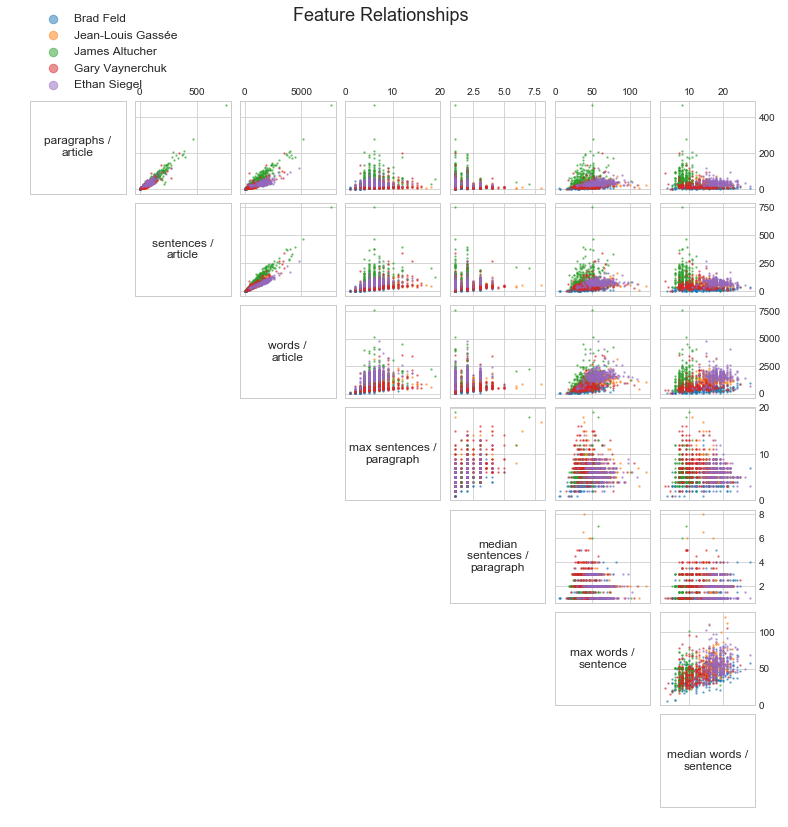

In [11]:
figure1 = plot_feature_scatters(articles_metrics,
                ['Brad Feld', 'Jean-Louis Gassée',
                 'James Altucher', 'Gary Vaynerchuk', 'Ethan Siegel'],
                ['article_num_paragraphs', 'article_num_sentences', 'article_num_words',
                 'paragraphs_max_sentences', 'paragraphs_median_sentences',
                 'sentences_max_words', 'sentences_median_words'],
                ['paragraphs /\narticle', 'sentences /\narticle', 'words /\narticle',
                 'max sentences /\nparagraph', 'median\nsentences /\nparagraph',
                 'max words /\nsentence', 'median words /\nsentence'])
plt.show()

From the scatter plots above it appears that a separation to some degree would be possible. For example, the plot for "words / article" vs "max words / sentence" shows distinct clusters for individual authors. Although the clusters seem to overlap quite a bit.

We will run a few classifier models and see what prediction accuracy we can achieve on a training data set. First, we will try the decision tree algorithm.

In [12]:
# split labels into separate data frame
data = articles_metrics
labels = data[['author']]
data = data.drop('author', 1)

# shuffle training test split
X_train, X_test, y_train, y_test = train_test_split(data, labels,
                                                    test_size=0.25,
                                                    random_state=23)

# decision tree prediction model
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
score_train = accuracy_score(y_train, clf.predict(X_train))
score_test = accuracy_score(y_test, clf.predict(X_test))

# report decision tree results
print('decision tree classifier:')
print('-------------------------\n')
print('prediction accuracy score on training data set: {:.2f}%'.format(score_train*100))
print('prediction accuracy score on test data set: {:.2f}%'.format(score_test*100))

decision tree classifier:
-------------------------

prediction accuracy score on training data set: 99.98%
prediction accuracy score on test data set: 33.87%


Nearly 100% on the training data! That's awesome!

Ok.... just joking ;-)

On unseen data the accuracy is around 33% (the value will vary slightly with each run). I think that's not too bad for a model that tries to guess the author of an article only based on the number of words in articles, paragraphs and sentences. The model does not take anything of the article content into account. The 100% accuracy on the training data means the model is extremly biased. It would be interesting to see if a grid search can find a better set of parameters.

In [13]:
def grid_search(X_train, y_train):
    # setup grid search
    cv_sets = ShuffleSplit(n_splits=10, test_size = 0.25, random_state = 23)
    learning_model = tree.DecisionTreeClassifier()
    params = {'max_depth': list(range(1,30)),
              'min_samples_split': list(range(2,50))}
    scoring_fnc = make_scorer(accuracy_score, greater_is_better=True)
    grid = GridSearchCV(estimator=learning_model,
                        param_grid=params,
                        scoring=scoring_fnc,
                        cv=cv_sets,
                        verbose=2)

    # run grid search
    grid = grid.fit(X_train, y_train)
    best_clf = grid.best_estimator_
    return best_clf

def get_classifier():
    '''
    Get the best classifier. Run grid search and save the best classifier to
    a pickle file. If the pickle file exists load the best classifier from file
    instead of running grid search again. This saves time in subsequent runs 
    of the Notebook.
    '''
    pickle_file = 'Model 2 Basic Article Metrics - grid search best estimator.pickle'
    if os.path.isfile(pickle_file):
        with open(pickle_file,'rb') as f:
            best_clf = pickle.loads(f.read())
    else:
        best_clf = grid_search(X_train, y_train)
        with open(pickle_file, 'wb') as f:
            s = pickle.dumps(best_clf)
            f.write(s)
    return best_clf

In [14]:
best_clf = get_classifier()
score_test = accuracy_score(y_test, best_clf.predict(X_test))
print('GridSearch prediction accuracy score on test data set: {:.2f}%'.format(score_test*100))
print('best parameters:')
print('    max_depth:{0}'.format(best_clf.get_params()['max_depth']))
print('    min_samples_split:{0}'.format(best_clf.get_params()['min_samples_split']))

GridSearch prediction accuracy score on test data set: 36.27%
best parameters:
    max_depth:10
    min_samples_split:23


The optimisation of two parameters with grid search gains us three more percentage points to 36%. A little bit better.

For comparison we will run the logistic regression algorithm and see if that yields better results. 

In [15]:
# logistic regression prediction model
clf = linear_model.LogisticRegression()
clf = clf.fit(X_train, y_train.values.ravel())
score_train = accuracy_score(y_train, clf.predict(X_train))
score_test = accuracy_score(y_test, clf.predict(X_test))

# report logistic regression results
print('\nlogistic regression classifier:')
print('-------------------------------\n')
print('prediction accuracy score on training data set: {:.2f}%'.format(score_train*100))
print('prediction accuracy score on test data set: {:.2f}%'.format(score_test*100))


logistic regression classifier:
-------------------------------

prediction accuracy score on training data set: 34.69%
prediction accuracy score on test data set: 32.20%


With 32% accuracy the result is 4% below what has been achieved with an (grid search) optimised decision tree algorithm.

In [16]:
# TODO: use PCA to find the most citical features of the basic article metrics model

## Model 3: Bag-of-Words - Word Count

In our next model we will use the vocabulary to build our prediction model. We will implement a the bag-of-words algorithm. Bag-of-Words is a very simple but often suprisingly effective algorithm. It takes all the different words in a training set and uses them as features. Each article is then transformed into a feature vector by marking the occurrance of each feature (=word). There are a few variations of Bag-of-Words. In it's basic form each vector counts the number of occurences for each word. This is what we are going to use in this Model 3. In the next section (Model 4) will use the term frequency–inverse document frequency (TFIDF) approach to build the Bag-of-Words vectors.

The code cell below defines a number of functions. The approach to define functions vs. directly executed code cells has been choosen to make the code reuseable for the next model in the following section.

Besides the training, predicting and scoring functionalties the code implementes two additional capabilities: 1.) it allows trained classifiers to be saved to or loaded from disk. This saves time when the Notebook is run multiple times. The model needs to be trained only once. 2.) The model can be trained with different classifiers. During experiementation very often different classifiers (e.g. logistic regression, decision tree, SVM) are tested to evaluate which one is most suitable for a problem.

In [48]:
def train(articles_train, pickle_file, classifiers, vectorizer_type):
    """ This function is called to either load a trained model from disk
    or to start the training. A trained model is loaded automatically 
    when the file exists.
    """
    if os.path.isfile(pickle_file):
        vectorizer, trained_classifiers = load_trained_classifiers(pickle_file)
    else:
        vectorizer, trained_classifiers = train_classifiers(articles_train,
                                                            classifiers,
                                                            vectorizer_type)
        save_trained_classifiers(vectorizer, trained_classifiers, pickle_file)
    return vectorizer, trained_classifiers

def load_trained_classifiers(pickle_file):
    """ Load a trained model from disk.
    """
    with open(pickle_file,'rb') as f:
        saved_items = pickle.loads(f.read())
    trained_classifiers = saved_items['trained_classifiers']
    vectorizer = saved_items['vectorizer']
    return vectorizer, trained_classifiers

def save_trained_classifiers(vectorizer, trained_classifiers, pickle_file):
    """ Save a trained model to disk. For Bag-of-Words there are two elements
    that need to be saved: the classifiers that have been trained (e.g. logistic
    regression, SVM) and the vectorizer. The vectorizer is the object that contains
    the vocabulary that has been trained from the training data set. The vecorizer
    is required later on to transform any given text into a vector representation.
    """
    saved_items = {'trained_classifiers': trained_classifiers,
                   'vectorizer': vectorizer}
    with open(pickle_file, 'wb') as f:
        s = pickle.dumps(saved_items)
        f.write(s)

def train_classifiers(articles_train, classifiers, vectorizer_type):
    """ This function performs the training for each classifier. The desired 
    classifieres are given as a list of dictionaries. Each entry spacifies an
    'algorithm' and the 'display_text'.
    """
    vectorizer, X_train = fit_transform_vectors(articles_train, vectorizer_type)
    y_train = articles_train[['author']]
    trained_classifiers = []
    for classifier in classifiers:
        classifier_algorithm = classifier['algorithm']
        display_text = classifier['display_text']
        clf = train_classifier(X_train, y_train, classifier_algorithm)
        trained_classifiers.append({'clf': clf, 'display_text': classifier['display_text']})
    return vectorizer, trained_classifiers

def train_classifier(data, labels, classifier_algorithm):
    """ Train a single classifier.
    """
    X_train = data
    y_train = labels
    clf = classifier_algorithm
    clf = clf.fit(X_train, y_train.values.ravel())
    return clf

def fit_transform_vectors(articles, vectorizer):
    """ Build the vocabulary during training.
    """
    data = pre_process_articles(articles)
    data_vectorized = vectorizer.fit_transform(data)
    return vectorizer, data_vectorized

def transform_vectors(articles, vectorizer):
    """ Transform a list of articles into Bag-of-Words vectors. This is used
    once a mopdel has been trained to transform articles in preparation for
    prediction.
    """
    articles = pre_process_articles(articles)
    articles = vectorizer.transform(articles)
    return articles

def pre_process_articles(articles, as_string=True):
    # join all articles to one string in preparation for hash calculation
    data = ''.join([article['body'] for index, article in articles.iterrows()])
    # calculate MD5 hash across all articles
    m = hashlib.md5()
    m.update(data.encode('utf-8'))
    md5_digest = m.hexdigest()
    pickle_file_name = 'pre_processed_articles_' + md5_digest + '.pickle'
    # load from disk or pre-process articles and save to disk
    if os.path.isfile(pickle_file_name):
        with open(pickle_file_name,'rb') as f:
            data = pickle.loads(f.read())
    else:
        data = [pre_process_text(article['body'], as_string) for index, article in articles.iterrows()]
        with open(pickle_file_name, 'wb') as f:
            s = pickle.dumps(data)
            f.write(s)
    return data

# def pre_process_text(article): # buggy function
#     """ Some preprocessing and cleaning tasks to be applied to the raw input text
#     of an article.
#     """
#     stop_words = set(stopwords.words('english'))
#     porter = PorterStemmer()
#     # tokenize article into words
#     words = tokenize_words(article)['words']
#     # remove stop words
#     words = [word for word in words if not word in stop_words]
#     # reduce words to its base and make all words lowercase
#     words = set([porter.stem(word) for word in words])
#     processed_text = ' '.join(words)
#     return processed_text

def pre_process_text(article, as_string=True): # fixed function
    """ Some preprocessing and cleaning tasks to be applied to the raw input text
    of an article.
    """
    stop_words = set(stopwords.words('english'))
    porter = PorterStemmer()
    # tokenize article into words
    words = tokenize_words(article)['words']
    # lower case
    words = [word.lower() for word in words]
    # remove stop words
    words = [word for word in words if not word in stop_words]
    # reduce words to its base and make all words lowercase
    words = [porter.stem(word) for word in words]
    # remove punctuation from word list
    re_punc = re.compile('[%s]' % re.escape(string.punctuation + '—'))
    words = [re_punc.sub('', w) for w in words]
    if as_string:
        # return as single string, required for, e.g., count or TFDIF vectorizers
        processed_text = ' '.join(words)
    else:
        # return list of words, required for, e.g., Word2Vec models
        processed_text = words
    return processed_text

Next we will utilize the functions above to build our model. A model will be represented as a Python class. This design decision was driven by a view that our model should be "productized" to some degree. A user of our WhoWroteThis model will want to use a simple and straighforward interface. She should be able to pass in a list of articles in human readable text format and all the activities around text preprocessing, cleaning or vectorizing the data will be hidden.

In [18]:
class Model_Bag_of_Words:
    
    def __init__(self, pickle_file):
        """ The user of this class can specify the file name under which 
        the trained model will be saved to disk.
        
        As of now the model is fixed to autmatically train the following
        classifiers: logistic regression, decision tree and support vector
        machine (SVM).
        """
        self.pickle_file = pickle_file
        self.classifiers = [
            {'algorithm': linear_model.LogisticRegression(),
             'display_text': 'logistic regression classifier'},
            {'algorithm': tree.DecisionTreeClassifier(),
             'display_text': 'decision tree classifier'},
            {'algorithm': svm.SVC(probability=True),
             'display_text': 'SVM classifier'}
        ]
        self.vectorizer = None
        self.trained_classifiers = None

    def train(self, articles_train, vectorizer_type):
        """ Train the model on the various classifiers.
        """
        self.vectorizer, self.trained_classifiers = train(articles_train,
                                                          self.pickle_file,
                                                          self.classifiers,
                                                          vectorizer_type)

    def predict(self, articles, classifier_type):
        """ For a given list of articles and the classifier 
        type (logistic regression, decision tree and SVM) predict the
        authors.
        """
        for clf in self.trained_classifiers:
            if clf['display_text'] == classifier_type:
                break
        articles = transform_vectors(articles, self.vectorizer)
        prediction = pd.DataFrame({'author': clf['clf'].classes_,
                                   'probability': clf['clf'].predict_proba(articles)[0]})
        return prediction
    
    def score(self, articles):
        """ Score prediction accuracy for a given list of articles.
        """
        labels_actual = articles[['author']]
        articles = transform_vectors(articles, self.vectorizer)
        clf_predictions = []
        for clf in self.trained_classifiers:
            labels_predicted = clf['clf'].predict(articles)
            clf_predictions.append({'classifier': clf['display_text'],
                                    'labels_predicted': labels_predicted})
            score = accuracy_score(labels_actual, labels_predicted)
            print('{} prediction accuracy score : {:.2f}%'.format(clf['display_text'], score*100))
        return clf_predictions

We run our Bag-of-Words model with word counts. Please note the strongly simplified interface by using the `Model_Bag_of_Words` class. It allows to work directly with the article texts and hides the machine learning "pipeline" (preprocessing, cleaning, vectorization, training of various classifiers).

In [19]:
# prediction based on word count
articles_train, articles_test = train_test_split(articles, test_size=0.25, random_state=23)
model_WordCount = Model_Bag_of_Words('Model 3 Bag-of-Words - Word Count.pickle')
print('training the model\n')
model_WordCount.train(articles_train, CountVectorizer())
print('number of training articles: {}'.format(len(articles_train)))
print('size of the vocabulary = length of the feature vector: {}'.\
      format(len(model_WordCount.vectorizer.vocabulary_)))
print('\nscoring the training data:\n')
model_WordCount.score(articles_train)
print('\nscoring the test data:\n')
clf_predictions = model_WordCount.score(articles_test)

training the model

number of training articles: 5756
size of the vocabulary = length of the feature vector: 62797

scoring the training data:

logistic regression classifier prediction accuracy score : 100.00%
decision tree classifier prediction accuracy score : 100.00%
SVM classifier prediction accuracy score : 37.40%

scoring the test data:

logistic regression classifier prediction accuracy score : 93.12%
decision tree classifier prediction accuracy score : 75.61%
SVM classifier prediction accuracy score : 34.18%


Using the logistic regression classifier gets us well above 96% prediction accuracy on the test data set. That's not bad! It appears that simply counting the word frequency is already a very strong differentiator between authors. It seems to confirm our intuition that a person is able to differentiate between authors by what they write about. Different topics will naturally use different vocabulary. For future research (not pursued in this project) it might be interesting to research how the classifier works for authors that write about the same or similar topics.

From the accuracy scores on training and test data we can see that the SVM classifier doesn't perform so well on this particular problem. This comes a bit as a surprise. According to the [scikit learn documentation](http://scikit-learn.org/stable/modules/svm.html) SVM is a classifier that generally is effective in high dimensional space and, more importantly, is "still effective in cases where number of dimensions is greater than the number of samples". In our case the number of 51,770 dimensions (= features) is significantly higher than the 5,756 samples (= number of training articles). Perhaps, because in our case the number of dimensions is almost ten times the number of samples make SVM unsuitable for our problem. The SVM library in scikit learn offers options for optimisation such as various classifiers (SVC, NuSVC and LinearSVC) and different kernel functions. For this project SVM has not been pursued further as the initial results (see above) are way below what the logistic regression classifier achieved.

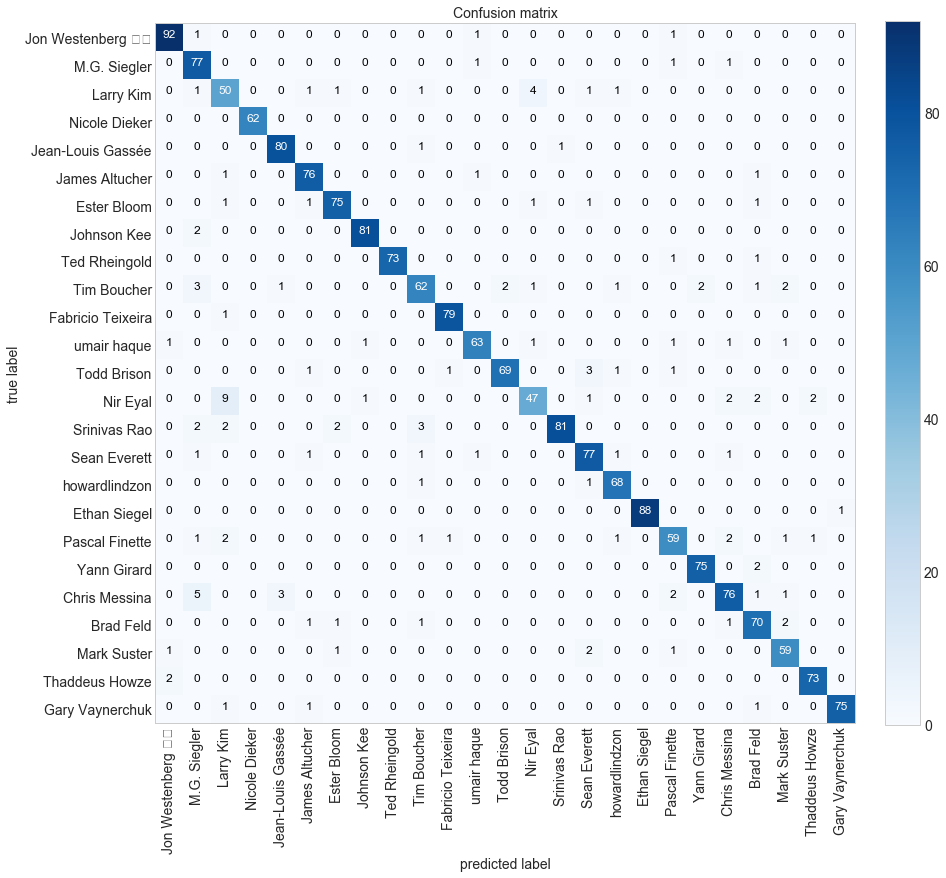

In [20]:
# display confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    im = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size=14)
    cb = plt.colorbar(im, fraction=0.046, pad=0.04)
    cb.ax.tick_params(labelsize=14)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, size=14)
    plt.yticks(tick_marks, classes, size=14)
    plt.grid(False)

    fmt = 'd'
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 size=12,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('true label', size=14)
    plt.xlabel('predicted label', size=14)
    
# Compute confusion matrix
y_test = articles_test[['author']]
for clf in clf_predictions:
    y_predict = clf['labels_predicted']
    if clf['classifier'] == 'logistic regression classifier':
        break
cnf_matrix = confusion_matrix(y_test, y_predict)
np.set_printoptions(precision=2)
class_names = list(set(labels['author']))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()

#TODO: Check the total in the confusion matrix. I have the feeling it doesn't add up.

## Model 4: Bag-of-Words - TFIDF

With all the code developed for Model 3 with reusability in mind we can now quickly implement another model that utlizes the term frequency–inverse document frequency (TFIDF) approach. In TFIDF, similar to word count, each word represents a feature. Each word is assigned a weight factor that is higher the more often a word occurs in an article. However, at the same time the weight of a word is reduced the more often it occurs across other articles. The idea behind TFIDF is that words that occur more across multiple articles carry less meaning then specialised words that occur within a smaller number of articles.

In the code cell below we only  replace the `CountVectorizer()` vectorizer with the `TfidfVectorizer()` vectorizer.

In [21]:
# prediction based on term frequency–inverse document frequency (TFIDF)
articles_train, articles_test = train_test_split(articles, test_size=0.25, random_state=23)
model_TFIDF = Model_Bag_of_Words('Model 4 Bag-of-Words - TFIDF.pickle')
print('training the model\n')
vectorizer = TfidfVectorizer()
model_TFIDF.train(articles_train, vectorizer)
print('number of training articles: {}'.format(len(articles_train)))
print('size of the vocabulary = length of the feature vector: {}'.\
      format(len(model_TFIDF.vectorizer.vocabulary_)))
print('\nscoring the training data:\n')
model_TFIDF.score(articles_train)
print('\nscoring the test data:\n')
clf_predictions = model_TFIDF.score(articles_test)

training the model

number of training articles: 5756
size of the vocabulary = length of the feature vector: 62797

scoring the training data:

logistic regression classifier prediction accuracy score : 98.26%
decision tree classifier prediction accuracy score : 100.00%
SVM classifier prediction accuracy score : 4.29%

scoring the test data:

logistic regression classifier prediction accuracy score : 91.87%
decision tree classifier prediction accuracy score : 74.47%
SVM classifier prediction accuracy score : 3.13%


The performance of the TFIDF model with logistic regression is almost identical to the word count model described in the previous section.

## Model 5: Bag-of-Words - Reduced Vocabulary




In [22]:
def get_vocabulary(articles, ngrams):
    data = pre_process_articles(articles)
    vectorizer = CountVectorizer(ngram_range=(ngrams, ngrams))
    data_vectorized = vectorizer.fit_transform(data)
    vocabulary = pd.DataFrame({'token': vectorizer.get_feature_names(),
                               'occurrence': np.asarray(data_vectorized.sum(axis=0)).ravel()})
    vocabulary = vocabulary[['token', 'occurrence']].sort_values('occurrence', ascending=False)
    vocabulary = vocabulary.reset_index().drop(['index'], axis=1)
    return vocabulary

def reduce_vocabulary(vocabulary, min_occurrence):
    vocabulary_reduced = vocabulary[vocabulary['occurrence']>min_occurrence]
    return vocabulary_reduced

def vocabulary_to_dict(vocabulary):
    # new index starting from 0 to total number of tokens
    vocabulary = vocabulary.reset_index().drop(['occurrence'], axis=1)
    # make column token the new index
    vocabulary = vocabulary.set_index('token')
    # transform into dict object
    vocabulary_dict = vocabulary.to_dict()['index']
    return vocabulary_dict

In [23]:
#
# prediction based on word count
#

# split training and test data
articles_train, articles_test = train_test_split(articles, test_size=0.25, random_state=23)

# reduce vocabulary
min_occurrence = 4
ngrams = 1
vocabulary = get_vocabulary(articles_train, ngrams)
vocabulary = reduce_vocabulary(vocabulary, min_occurrence)
vocabulary_dict = vocabulary_to_dict(vocabulary)

# run the model
model_ReducedVocab = Model_Bag_of_Words('Model 5 Bag-of-Words - Reduced Vocabulary.pickle')
print('training the model\n')
model_ReducedVocab.train(articles_train, CountVectorizer(vocabulary=vocabulary_dict))
print('number of training articles: {}'.format(len(articles_train)))
print('size of the vocabulary = length of the feature vector: {}'.\
      format(len(model_ReducedVocab.vectorizer.vocabulary_)))
print('\nscoring the training data:\n')
model_ReducedVocab.score(articles_train)
print('\nscoring the test data:\n')
clf_predictions = model_ReducedVocab.score(articles_test)

training the model

number of training articles: 5756
size of the vocabulary = length of the feature vector: 18322

scoring the training data:

logistic regression classifier prediction accuracy score : 100.00%
decision tree classifier prediction accuracy score : 100.00%
SVM classifier prediction accuracy score : 57.19%

scoring the test data:

logistic regression classifier prediction accuracy score : 92.91%
decision tree classifier prediction accuracy score : 75.77%
SVM classifier prediction accuracy score : 52.84%


## Model 6: Bag-of-Words - Bigrams

In [24]:
# split training and test data
articles_train, articles_test = train_test_split(articles, test_size=0.25, random_state=23)

# run the model
model_Bigrams = Model_Bag_of_Words('Model 6 Bag-of-Words - Bigrams.pickle')
print('training the model\n')
model_Bigrams.train(articles_train, CountVectorizer(ngram_range=(2, 2)))
print('number of training articles: {}'.format(len(articles_train)))
print('size of the bigram vocabulary = length of the feature vector: {}'.\
      format(len(model_Bigrams.vectorizer.vocabulary_)))
print('\nscoring the training data:\n')
model_Bigrams.score(articles_train)
print('\nscoring the test data:\n')
clf_predictions = model_Bigrams.score(articles_test)

training the model

number of training articles: 5756
size of the bigram vocabulary = length of the feature vector: 1245153

scoring the training data:

logistic regression classifier prediction accuracy score : 100.00%
decision tree classifier prediction accuracy score : 100.00%
SVM classifier prediction accuracy score : 4.29%

scoring the test data:

logistic regression classifier prediction accuracy score : 88.95%
decision tree classifier prediction accuracy score : 72.80%
SVM classifier prediction accuracy score : 3.13%


## Model 7: Bag-of-Words - Reduced Bigrams

In [25]:
# split training and test data
articles_train, articles_test = train_test_split(articles, test_size=0.25, random_state=23)

# reduce vocabulary
min_occurrence = 4
ngrams = 2
vocabulary = get_vocabulary(articles_train, ngrams)
vocabulary = reduce_vocabulary(vocabulary, min_occurrence)
vocabulary_dict = vocabulary_to_dict(vocabulary)

# run the model
model_Bigrams = Model_Bag_of_Words('Model 7 Bag-of-Words - Reduced Bigrams.pickle')
print('training the model\n')
model_Bigrams.train(articles_train, CountVectorizer(vocabulary=vocabulary_dict,
                                                    ngram_range=(2, 2)))
print('number of training articles: {}'.format(len(articles_train)))
print('size of the bigram vocabulary = length of the feature vector: {}'.\
      format(len(model_Bigrams.vectorizer.vocabulary_)))
print('\nscoring the training data:\n')
model_Bigrams.score(articles_train)
print('\nscoring the test data:\n')
clf_predictions = model_Bigrams.score(articles_test)

training the model

number of training articles: 5756
size of the bigram vocabulary = length of the feature vector: 75070

scoring the training data:

logistic regression classifier prediction accuracy score : 99.86%
decision tree classifier prediction accuracy score : 99.97%
SVM classifier prediction accuracy score : 6.24%

scoring the test data:

logistic regression classifier prediction accuracy score : 88.59%
decision tree classifier prediction accuracy score : 72.80%
SVM classifier prediction accuracy score : 4.74%


## Model 8: Word Embeddings & CNN

The 7,675 articles contain 3,519,027 words (after pre-processing).

TODO: test if keeping stop words improves accuracy.

"Yoav Goldberg, in his primer on deep learning for natural language
processing, comments that neural networks in general offer better performance than classical
linear classifiers, especially when used with pre-trained word embeddings."

We need a slightly different preprocessing, no stemming keep lower and case

In [141]:
def pre_process_article(article):
    """ Some preprocessing and cleaning tasks to be applied to the raw input text
    of an article.
    """
    stop_words = set(stopwords.words('english'))
    words = tokenize_words(article)['words']
    # remove punctuation from word list
    re_punc = re.compile('[%s]' % re.escape(string.punctuation + '—'))
    words = [re_punc.sub('', w) for w in words]
    words = [word for word in words if not word=='']
    # remove words that are not completely alphabetic
    words = [word for word in words if word.isalpha()]
    # remove stop words
    words = [word for word in words if not word.lower() in stop_words]
    # remove short words
    words = [word for word in words if len(word)>1]
    processed_article = words
    return processed_article

class IntegerEncoder():
    
    def __init__(self):
        self.learn_vocab=False
        self.curr_int = 1
        self.word_to_int = {'': 0}
        self.int_to_word = {0: ''}
        
    def encode_article(self, article):
        return [self.word_to_integer(word) for word in article]
    
    def word_to_integer(self, word):
        if not word in self.word_to_int.keys() and self.learn_vocab:
            self.word_to_int[word] = self.curr_int
            self.int_to_word[self.curr_int] = word
            self.curr_int +=1
        if not word in self.word_to_int.keys() and self.learn_vocab==False:
            return 0
        return self.word_to_int[word]
    
def build_CNN(vocab_size, dims, max_length):
    model = Sequential()
    model.add(Embedding(vocab_size, dims, input_length=max_length))
    model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(25, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
    return model

In [142]:
# TODO: test with smaller padding of the articles
# TODO: test what if longest article is in test data set
# TODO: check how many words are encoded with 0

class Model_Embeddings_CNN:

    def __init__(self):
        self.int_encoder = IntegerEncoder()
        
    def train(self, articles_train, author_to_int, file):
        # pre-process the articles
        pre_processed_articles = [pre_process_article(article['body']) \
                                  for index, article in articles_train.iterrows()]
        # encode words to integers
        self.int_encoder.learn_vocab = True
        encoded_articles = [self.int_encoder.encode_article(article) \
                            for article in pre_processed_articles]
        # encode the author names to integers
        authors_encoded = [author_to_int[author] for author in list(articles_train['author'])]
        # get length of longest article
        article_lengths = pd.DataFrame([len(article) for article in encoded_articles],
                                       columns=['length'])
        self.max_length = article_lengths['length'].max()
        # pad article lenghts to longest article 
        padded_articles = pad_sequences(encoded_articles,
                                        maxlen=self.max_length,
                                        padding='post')
        self.vocab_size = len(self.int_encoder.word_to_int)
        # display CNN summary
        self.model = build_CNN(self.vocab_size, 100, self.max_length)
        self.model.summary()
        # fit CNN model and save learned model to file
        self.model.fit(padded_articles, authors_encoded, epochs=10, verbose=1)
        self.model.save(file)
        return pre_processed_articles, encoded_articles, padded_articles
        
    def predict(self, articles, author_to_int):
        # pre-process the articles
        pre_processed_articles = [pre_process_article(article['body']) \
                                  for index, article in articles.iterrows()]
        # encode words to integers
        self.int_encoder.learn_vocab = False
        encoded_articles = [self.int_encoder.encode_article(article) \
                            for article in pre_processed_articles]
        # pad article lenghts to longest article 
        padded_articles = pad_sequences(encoded_articles,
                                        maxlen=self.max_length,
                                        padding='post')
        # encode the author names to integers
        authors_encoded = [author_to_int[author] for author in list(articles['author'])]
        # TODO: add prediction code
        return pre_processed_articles, encoded_articles, padded_articles, authors_encoded
        
    def score(self, padded_articles, authors_encoded):
        loss, accuracy = self.model.evaluate(padded_articles, authors_encoded, verbose=1)
        return loss, accuracy


In [ ]:
# split training and test data
articles_train, articles_test = train_test_split(articles, test_size=0.25, random_state=23)
# create a mapping from author names to integers
author_to_int = {a: i for i, a in enumerate(set(articles['author']))}

model_Embeddings_CNN = Model_Embeddings_CNN()
prc_train, enc_train, pad_train = model_Embeddings_CNN.train(articles_train,
                                       author_to_int,
                                       'Model 8 Word Embedding & CNN - Learned Embedding.h5')
prc_test, enc_test, pad_test, enc_authors = model_Embeddings_CNN.predict(articles_test, author_to_int)
loss, accuracy = model_Embeddings_CNN.score(pad_test, enc_authors)
print('accuracy: {}%'.format(accuracy*100))


In [303]:
# load pre-trained GloVe embedding from ZIP file
embeddings_index = {}
with zipfile.ZipFile('glove.6B.zip', 'r') as zf:
    with zf.open('glove.6B.300d.txt', 'r') as f:
        for line in f:
            values = line.split()
            word = values[0].decode("utf-8")
            coefs = asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

In [304]:
# assign GloVe weights to the words in the training data set
embedding_matrix = zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

#TODO: save mapped GloVe weights for full dataset to disk

In [305]:
model_GloVe = Sequential()
# TODO: test with trainable=True
model_GloVe.add(Embedding(vocab_size, 300, 
                          weights=[embedding_matrix], 
                          input_length=max_length,
                          trainable=False))
model_GloVe.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
model_GloVe.add(MaxPooling1D(pool_size=2))
model_GloVe.add(Flatten())
model_GloVe.add(Dense(10, activation='relu'))
model_GloVe.add(Dense(25, activation='softmax'))
model_GloVe.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
model_GloVe.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 12580, 300)        22887000  
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 12573, 32)         76832     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 6286, 32)          0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 201152)            0         
_________________________________________________________________
dense_32 (Dense)             (None, 10)                2011530   
_________________________________________________________________
dense_33 (Dense)             (None, 25)                275       
Total params: 24,975,637
Trainable params: 2,088,637
Non-trainable params: 22,887,000
________________________________________________________

In [306]:
model_GloVe.fit(padded_articles, authors_encoded, epochs=10, verbose=1)
model_GloVe.save('Model 8 Word Embedding & CNN - GloVe 300d Embedding.h5')

Epoch 1/10
5756/5756 [==============================] - 1410s 245ms/step - loss: 3.1290 - acc: 0.0808
Epoch 2/10
5756/5756 [==============================] - 1432s 249ms/step - loss: 2.5747 - acc: 0.2502
Epoch 3/10
5756/5756 [==============================] - 1458s 253ms/step - loss: 1.8611 - acc: 0.4319
Epoch 4/10
5756/5756 [==============================] - 1429s 248ms/step - loss: 1.2857 - acc: 0.6062
Epoch 5/10
5756/5756 [==============================] - 1396s 243ms/step - loss: 0.9115 - acc: 0.7389
Epoch 6/10
5756/5756 [==============================] - 1403s 244ms/step - loss: 0.6689 - acc: 0.8284
Epoch 7/10
5756/5756 [==============================] - 1400s 243ms/step - loss: 0.4824 - acc: 0.8919
Epoch 8/10
5756/5756 [==============================] - 1401s 243ms/step - loss: 0.3496 - acc: 0.9281
Epoch 9/10
5756/5756 [==============================] - 1404s 244ms/step - loss: 0.2767 - acc: 0.9548
Epoch 10/10
5756/5756 [==============================] - 1399s 243ms/step - loss: 

In [307]:
loss, accuracy = model_GloVe.evaluate(padded_articles, authors_encoded, verbose=1)
print('accuracy: {}%'.format(accuracy*100))

5756/5756 [==============================] - 681s 118ms/step
accuracy: 97.55038221815214%


In [310]:
articles_processed = [pre_process_article(article['body']) \
                      for index, article in articles_test.iterrows()]
encoded_articles = [one_hot(article, vocab_size) for article in articles_processed]
padded_articles = pad_sequences(encoded_articles, maxlen=max_length, padding='post')

article_authors = list(articles_test['author'])
author_to_int = {a: i for i, a in enumerate(set(articles_train['author']))}
authors_encoded = [author_to_int[author] for author in article_authors]

# predict test data set
loss, accuracy = model_GloVe.evaluate(padded_articles, authors_encoded, verbose=1)
print('accuracy: {}%'.format(accuracy*100))

1919/1919 [==============================] - 299s 156ms/step
accuracy: 34.80979675517348%


In [ ]:
def plot_PCA_projection(X, words):
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    plt.scatter(result[:, 0], result[:, 1])
    for i, word in enumerate(words):
        plt.annotate(word, xy=[result[i, 0], result[i, 1]])

X = model[words]
plot_PCA_projection(X, words)

In [220]:
filename = 'GoogleNews-vectors-negative300.bin'
GoogleNews_model = None

#GoogleNews_model = KeyedVectors.load_word2vec_format(filename, binary=True)
#GoogleNews_vocab = list(GoogleNews_model.wv.vocab)

In [ ]:
# remove all words that are not part of the Google Word2Vec vocabulary
words_cleaned = [word for word in words if word in GoogleNews_vocab]
print(len(words))
print(len(words_cleaned))

In [ ]:
print(words_cleaned)
X = model[words_cleaned]
plot_PCA_projection(X, words_cleaned)

## Let's have some fun: the WhoWroteThis app

Now that we have a working prediction model let's build a little app that makes use of the model we have trained and tested.

Run the cell below and follow the instructions shown in the output area.

Used glove.42B.300d.zip as this was trained on Wikipedia. Probably close to our problem in terms of article length and content structure

In [29]:
def on_button_clicked(button):
    test_article = pd.DataFrame([text_input_box.value], columns=['body'])
    predictions = model_WordCount.predict(test_article, 'logistic regression classifier')
    index = predictions['probability'].idxmax()
    author = predictions.loc[index]['author']
    probability = predictions.loc[index]['probability']*100
    print('I\'m {:.0f} percent certain that this was written by... {}.'.format(probability, author))

text_input_box = widgets.Textarea(
    value='',
    placeholder='Please paste an article here.',
    disabled=False,
    layout=Layout(width='700px', height='300px')
)
button = widgets.Button(
    description='Who wrote this?',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
)

print('From the list of Medium authors below pick one. Select an article and copy the')
print('text in the text box below. Press the "Who wrote this?" button and see whether')
print('the right author is predicted.\n')
with open('Medium_authors_25.txt','r') as f:
    author_urls = f.read()
print(author_urls)

button.on_click(on_button_clicked)
display(text_input_box, button)

From the list of Medium authors below pick one. Select an article and copy the
text in the text box below. Press the "Who wrote this?" button and see whether
the right author is predicted.

https://medium.com/@tedr/latest
https://medium.com/@garyvee/latest
https://medium.com/@NicoleDieker/latest
https://medium.com/@fabriciot/latest
https://medium.com/@esterbloom/latest
https://medium.com/@startswithabang/latest
https://medium.com/@girard_yann/latest
https://medium.com/@pfinette/latest
https://medium.com/@jonwestenberg/latest
https://medium.com/@chrismessina/latest
https://medium.com/@msuster/latest
https://medium.com/@howardlindzon/latest
https://medium.com/@umairh/latest
https://medium.com/@jaltucher/latest
https://medium.com/@JohnsonKee/latest
https://medium.com/@larrykim/latest
https://medium.com/@seanmeverett/latest
https://medium.com/@timboucher/latest
https://medium.com/@mgsiegler/latest
https://medium.com/@nireyal/latest
https://medium.com/@skooloflife/latest
https://medium.com/

A Jupyter Widget

A Jupyter Widget

>*"I can guarantee you a purity of 96%. I'm proud of that figure. It's a hard-earned figure, 96. However, this other product is 99 maybe even a touch beyond that. [...] but that last 3%, it may not sound like a lot but it is. It's tremendous. It's a tremendous gulf."*

>Gale Boetticher, Breaking Bad, season 4, episode 1


## Appendix

This section contains notes and code fragments not required for the Capstone project. These were often developed as part of trouble shooting activities and kept here for later reference.

In [98]:
#
# check for token collisions
#
# The one_hot function from the keras.preprocessing.text library was originally used
# to convert the words in articles to integer values. This was done as preparation to
# train a CNN. However, one_hot does not encode collision free. The code below has been
# used to access to what extend collisions occur.
#
# Running against a text corpus with 54,619 unique words one_hot caused 22,793 collisions.
# Meaning 22,793 integers were not uniquely mapped to single words. It is believed that this
# percentage of collisions significantly distorted the learning of the embedding CNN.
#

author_to_int = {a: i for i, a in enumerate(set(articles['author']))}
model_Embeddings_CNN = Model_Embeddings_CNN()
articles_processed, encoded_articles = model_Embeddings_CNN.train(articles, author_to_int)

encoded_to_word_mapping = {}
for i, article in enumerate(articles_processed):
    # process every article, this takes a while, show status update every 100 articles
    if i%100 == 0:
        print('{} articles processed'.format(i))
    # for each article generate a table that shows integer to word mapping
    encoded_to_word = pd.DataFrame({'encoded': encoded_articles[i],
                                    'word': article})
    # get the list of unique integer values in an article
    unique_encodes = set(encoded_to_word['encoded'])
    for unique_encode in unique_encodes:
        # For each integer get all the words that have been mapped against this
        # integer. In a collision free mapping this should generate a list of 
        # 1 - n occurrences of the same word (e.g. ['the', 'the', 'the', 'the'])
        words = list(encoded_to_word[encoded_to_word['encoded']==unique_encode]['word'].values)
        words = [word.lower() for word in words]
        # Add the list of words to a global dict that maps an integer
        # to the words. Again, in a collision free mapping this should be 
        # list of the same word listed one or more times.
        if encoded_to_word_mapping.get(unique_encode) is None:
            encoded_to_word_mapping[unique_encode] = words
        else:
            encoded_to_word_mapping[unique_encode] = encoded_to_word_mapping[unique_encode] + words

print('number of entries in encode to word map: {}'.format(len(encoded_to_word_mapping)))

# Now go through the list of integers and check that all articles
# mapped the same word against this integer.
found_something = False
for key in encoded_to_word_mapping.keys():
    if len(set(encoded_to_word_mapping[key]))>1:
        # There is more than one word mapped against one integer. This is
        # a collision!
        found_something = True
        print('{}: {}'.format(key, set(encoded_to_word_mapping[key])))
if not found_something:
    print('No collisions found!')

0 articles processed
100 articles processed
200 articles processed
300 articles processed
400 articles processed
500 articles processed
600 articles processed
700 articles processed
800 articles processed
900 articles processed
1000 articles processed
1100 articles processed
1200 articles processed
1300 articles processed
1400 articles processed
1500 articles processed
1600 articles processed
1700 articles processed
1800 articles processed
1900 articles processed
2000 articles processed
2100 articles processed
2200 articles processed
2300 articles processed
2400 articles processed
2500 articles processed
2600 articles processed
2700 articles processed
2800 articles processed
2900 articles processed
3000 articles processed
3100 articles processed
3200 articles processed
3300 articles processed
3400 articles processed
3500 articles processed
3600 articles processed
3700 articles processed
3800 articles processed
3900 articles processed
4000 articles processed
4100 articles processed
4200

In [99]:
#
# show article pre-processing and encoding of words to integer
#

# split training and test data
articles_train, articles_test = train_test_split(articles[:100], test_size=0.25, random_state=23)
# create a mapping from author names to integers
author_to_int = {a: i for i, a in enumerate(set(articles['author']))}

model_Embeddings_CNN = Model_Embeddings_CNN()
proc_art_train, enc_art_train = model_Embeddings_CNN.train(articles_train, author_to_int)
proc_art_test, enc_art_test = model_Embeddings_CNN.predict(articles_test)

i = 6

print('processed train article ({} words):'.format(len(proc_art_train[i])))
print('---------------------------------------')
print(proc_art_train[i])
print('\n')
print('encoded train article ({} numbers):'.format(len(enc_art_train[i])))
print('---------------------------------------')
print(enc_art_train[i])
print('\n')
print('processed test article ({} words):'.format(len(proc_art_test[i])))
print('---------------------------------------')
print(proc_art_test[i])
print('\n')
print('encoded test article ({} numbers):'.format(len(enc_art_test[i])))
print('---------------------------------------')
print(enc_art_test[i])
print('\n')

train_zip = pd.DataFrame({'encoded': enc_art_train[i],
                          'word': proc_art_train[i]})
test_zip = pd.DataFrame({'encoded': enc_art_test[i],
                          'word': proc_art_test[i]})
print('train zip:')
display(train_zip.sort_values('encoded'))
print('\n')
print('test zip:')
display(test_zip.sort_values('encoded'))
print('\n')

print('word ID matches between train and test article:')
matches = list(set(enc_art_train[i]) & set(enc_art_test[i]))
print(matches)
print('\n')
for match in matches:
    print('index: {}'.format(match))
    print('encoded train word: {}'.format(train_zip[train_zip['encoded']==match]['word'].values))
    print('encoded test word : {}'.format(test_zip[test_zip['encoded']==match]['word'].values))
print('\n')

processed train article (235 words):
---------------------------------------
['Apple', 'Platform', 'Layer', 'Bugs', 'word', 'platform', 'used', 'mean', 'something', 'technology', 'industry', 'Like', 'many', 'words', 'applied', 'many', 'different', 'things', 'almost', 'meaningless', 'Yesterday', 'started', 'seeing', 'stuff', 'MacOS', 'High', 'Sierra', 'blank', 'root', 'password', 'bug', 'took', 'deep', 'breath', 'clicked', 'first', 'link', 'saw', 'hoping', 'Onion', 'article', 'read', 'picked', 'jaw', 'floor', 'said', 'loud', 'Someone', 'Apple', 'got', 'fired', 'today', 'wondered', 'true', 'realized', 'probably', 'someone', 'probably', 'fired', 'Apple', 'deep', 'root', 'cause', 'analysis', 'bug', 'like', 'could', 'get', 'wild', 'part', 'OS', 'release', 'Later', 'day', 'pulled', 'Facetime', 'make', 'call', 'Amy', 'computer', 'sat', 'spun', 'contacts', 'seconds', 'Facetime', 'appeared', 'shrugged', 'thought', 'someone', 'Apple', 'fix', 'happened', 'hours', 'later', 'Thanksgiving', 'gave', 

,encoded,word
49,6,got
156,7,email
183,8,one
203,8,one
35,17,first
141,17,first
45,20,said
113,23,shared
125,32,would
88,65,someone




test zip:


,encoded,word
0,0,Prime
19,0,Predator
18,0,né
17,0,Shrike
15,0,bet
14,0,prime
32,0,Overview
35,0,blow
11,0,prime
7,0,prime




word ID matches between train and test article:
[418, 229, 230, 231, 232, 78, 17]


index: 418
encoded train word: ['pretty']
encoded test word : ['pretty']
index: 229
encoded train word: ['Originally']
encoded test word : ['Originally']
index: 230
encoded train word: ['published']
encoded test word : ['published']
index: 231
encoded train word: ['Feld']
encoded test word : ['Feld']
index: 232
encoded train word: ['Thoughts']
encoded test word : ['Thoughts']
index: 78
encoded train word: ['book']
encoded test word : ['book']
index: 17
encoded train word: ['first' 'first']
encoded test word : ['first']


